In [109]:
import numpy as np
import pandas as pd
import stockstats as st
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import pickle
import timeit

In [110]:
data = st.StockDataFrame.retype(pd.read_csv('/home/anupam/stockPrediction/data/^BSESN (5).csv'))
daysToForecast = 10

In [111]:
data.index = pd.to_datetime(data.index)
data.interpolate(method='time',inplace=True)
#data.dropna(inplace=True)

In [112]:
SMA5 = data['adj close'].rolling(window=5).mean()
SMA10 = data['adj close'].rolling(window=10).mean()
SMA20 = data['adj close'].rolling(window=20).mean()
data = pd.concat([data,SMA5,SMA10,SMA20],axis=1,sort=False)
data.columns.values[6] = 'sma5'
data.columns.values[7] = 'sma10'
data.columns.values[8] = 'sma20'

In [113]:
prev = 0
i = 1
def calc(diff,volume):
    "part of on balance volume"
    global i
    global prev
    if i == 1:
        i = 0
        prev = volume
        return volume
    elif diff > 0:
        value = prev = prev + volume
        return value
    elif diff < 0:
        value = prev = prev - volume
        return value
    elif diff == 0:
        value = prev
        return value

def OBV(data):
    "function to calculate on balance volume"
    data['prior close'] = data['adj close'].shift(1)
    data['diff'] = data['adj close'] - data['prior close']
    temp = [calc(x,y) for x,y in zip(data['diff'].values[1:],data['volume'].values[1:])]
    temp = temp + [0]
    temp = np.array(temp)
    data['obv'] = temp
    data['obv'] = data['obv'].shift(1)
    data.drop(['prior close','diff'],axis=1,inplace=True)
    return data

data = OBV(data)

In [114]:
data['macd']  #to calculate moving avrage convergence divergence
data['rsi_10']#to calculate relative strength index for 10 dsys
data['rsi_20']#to calculate relative strength index for 20 days
data['cci_20']#to calculate commodity channel index for 20 days
data['atr']   #to calculate average true range for 14 days
data['wr_14'] #to calculate williams%R for 14 days
data['kdjk']  #a stochastic oscillator
data['kdjd']  #a stochastic oscillator(here a is used so that cell doesn't display the series)
a = data['trix'] # to calculate triple exponentially smoothed moving average

/home/anupam/anaconda3/lib/python3.6/site-packages/stockstats.py:387: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: np.fabs(x - x.mean()).mean())


In [115]:
featureList = ['open', 'high', 'low', 'adj close','volume','sma5','sma10','sma20','macd','rsi_10', 'rsi_20','cci_20','atr','wr_14','kdjk','kdjd','obv','trix']
data1 = data[featureList]

In [116]:
data1.dropna(inplace=True)

In [117]:
data1.shape

(5278, 18)

In [118]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
data1Scaled = pd.DataFrame(scaler.fit_transform(data1),columns=featureList)

In [119]:
data1Scaled['Label'] = np.array(data1['adj close'].shift(-(daysToForecast)).values)

In [120]:
data2Scaled = data1Scaled.dropna(inplace=False)

In [121]:
l = data2Scaled.corr()['Label']
l

open         0.997824
high         0.997905
low          0.997916
adj close    0.997973
volume       0.181103
sma5         0.997740
sma10        0.997401
sma20        0.996707
macd         0.182463
rsi_10       0.087348
rsi_20       0.123564
cci_20       0.066223
atr          0.666327
wr_14       -0.067984
kdjk         0.069108
kdjd         0.077652
obv          0.918424
trix         0.062925
Label        1.000000
Name: Label, dtype: float64

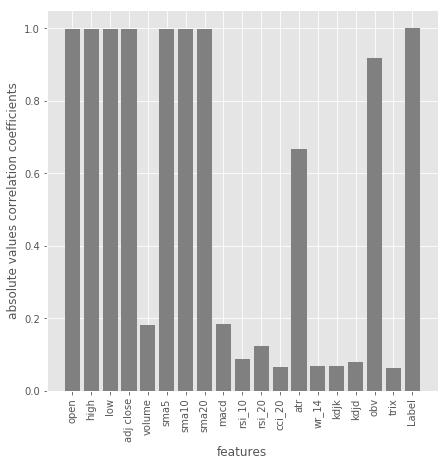

In [122]:
plt.figure(figsize=(7,7))
plt.bar(data2Scaled.columns.values,abs(data2Scaled.corr()['Label'].values),color='gray')
plt.xlabel('features')
plt.xticks(rotation=90)
plt.ylabel('absolute values correlation coefficients')
plt.show()

In [123]:
list = [column for column in l.index.values if 0.5<abs(l[column])<1]

In [124]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data2Scaled[list])
pcaData = pca.transform(data2Scaled[list])

In [125]:
components = ['PC' + str(x) for x in range(1,len(pca.explained_variance_)+1)]
varianceTable = pd.DataFrame({'Variance':pca.explained_variance_,'Variance %': pca.explained_variance_ratio_*100},index=components)

In [126]:
varianceTable

,Variance,Variance %
PC1,8.308972,92.889497
PC2,0.532379,5.951691
PC3,0.101138,1.130663
PC4,0.001995,0.022302
PC5,0.000273,0.003050
PC6,0.000136,0.001526
PC7,0.000052,0.000577
PC8,0.000050,0.000556
PC9,0.000012,0.000138


In [127]:
selectedComponents = [x for x,y in zip(range(len(pca.explained_variance_)),pca.explained_variance_) if y>=0.1]

In [128]:
componentTable = pd.DataFrame(index=list)
for x in selectedComponents:
    componentTable['PC' + str(x+1)] = pd.Series(pca.components_[x],index=list)

In [129]:
componentTable

,PC1,PC2,PC3
open,0.343859,-0.126900,0.093234
high,0.343996,-0.121508,0.092480
low,0.343671,-0.134465,0.089196
adj close,0.343839,-0.127684,0.089683
sma5,0.343888,-0.125485,0.093966
sma10,0.343919,-0.120871,0.100586
sma20,0.343958,-0.110943,0.113547
atr,0.254445,0.924650,0.282472
obv,0.327878,0.192627,-0.924730


In [130]:
pcaData = pd.DataFrame(data=pcaData) 

In [131]:
X = np.array(pcaData[selectedComponents])
y = np.array(data2Scaled['Label'])

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

In [134]:
# X_validation = X_train[-int((X_train.shape[0]*0.2)):]
# y_validation = y_train[-int((y_train.shape[0]*0.2)):]
# X_train = X_train[:-int((X_train.shape[0]*0.2))]
# y_train = y_train[:-int((y_train.shape[0]*0.2))]

In [135]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.35,shuffle=False)

In [136]:
regressor = MLPRegressor(hidden_layer_sizes=(10,),
                         activation='relu',
                         solver='adam',
                         learning_rate='adaptive',
                         max_iter=10000,
                         learning_rate_init=0.01,
                         alpha=0.01)
startTime = timeit.default_timer()
regressor.fit(X_train,y_train)
endTime = timeit.default_timer()
print("R-squared for training set = {}".format(regressor.score(X_train,y_train)))
print("R-squared for validation set = {}".format(regressor.score(X_validation,y_validation)))
print("R-squared for test set = {}".format(regressor.score(X_test,y_test)))
print("MSE:{}".format(mean_squared_error(y_test,regressor.predict(X_test))))
print("MAE:{}".format(mean_absolute_error(y_test,regressor.predict(X_test))))
print("MAPE:{} %".format((abs((y_test-regressor.predict(X_test)))/y_test).mean()*100))
print("Time:{}".format(endTime-startTime))

R-squared for training set = 0.989844026709521
R-squared for validation set = 0.8956207455211034
R-squared for test set = 0.8065207431260031
MSE:2104407.8180178795
MAE:1187.4508084546646
MAPE:3.9756971656782283 %
Time:5.3925431040006515


with open("neuralNet.pickle","wb") as nn:
    pickle.dump(regressor,nn)

In [137]:
pickle_in = open("neuralNet.pickle","rb")
bestModel = pickle.load(pickle_in)
print("R-squared for training set = {}".format(bestModel.score(X_train,y_train)))
print("R-squared for validation set = {}".format(bestModel.score(X_validation,y_validation)))
print("R-squared for test set = {}".format(bestModel.score(X_test,y_test)))
print("MSE:{}".format(mean_squared_error(y_test,bestModel.predict(X_test))))
print("MAE:{}".format(mean_absolute_error(y_test,bestModel.predict(X_test))))
print("MAPE:{} %".format((abs((y_test-bestModel.predict(X_test)))/y_test).mean()*100))

R-squared for training set = 0.9901831838425714
R-squared for validation set = 0.9120681170702146
R-squared for test set = 0.8899498935641168
MSE:1196977.4336491018
MAE:892.7555211635085
MAPE:3.035818343611445 %


In [138]:
predict = bestModel.predict(np.concatenate((X_train,X_validation,X_test),axis=0))

In [139]:
df = pd.DataFrame(data=data1['adj close'])
df['Forecasted close'] =np.concatenate((np.array([np.nan for x in range(daysToForecast)]), predict),axis=0)
df.dropna(inplace=True)

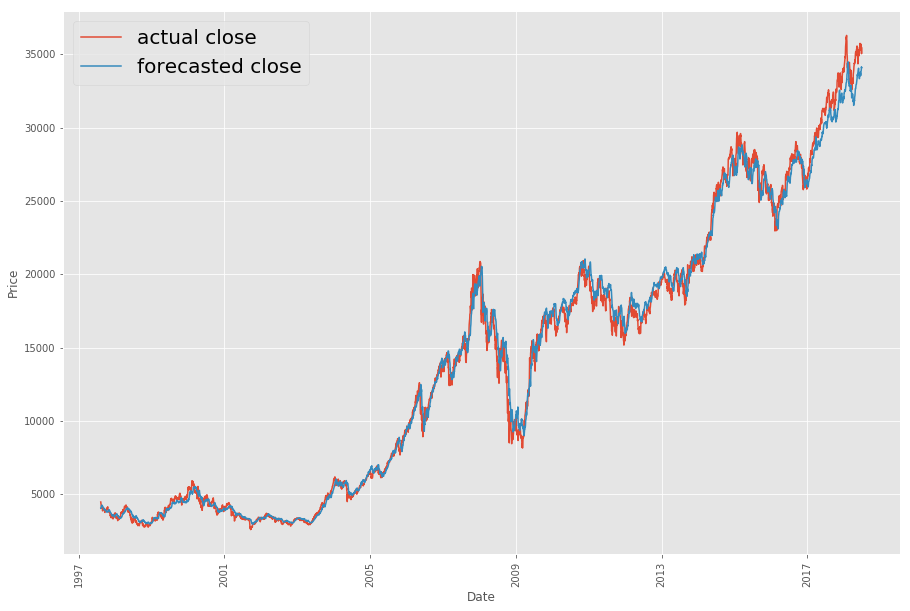

In [140]:
plt.figure(figsize=(15,10))
plt.plot(df['adj close'],label='actual close')
plt.plot(df['Forecasted close'],label='forecasted close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.legend(fontsize=20)
plt.show()

In [141]:
X_test.shape

(1054, 3)

In [142]:
X_validation.shape

(1475, 3)

In [143]:
X_train.shape

(2739, 3)